In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cp '/content/drive/MyDrive/dataset.zip' 'dataset.zip'

In [ ]:
!unzip '/content/drive/MyDrive/dataset.zip'

Archive:  /content/drive/MyDrive/dataset.zip
   creating: dataset/
   creating: dataset/without_mask/
  inflating: dataset/without_mask/0.jpg  
  inflating: dataset/without_mask/0_0_aidai_0014.jpg  
  inflating: dataset/without_mask/0_0_aidai_0029.jpg  
  inflating: dataset/without_mask/0_0_aidai_0043.jpg  
  inflating: dataset/without_mask/0_0_aidai_0074.jpg  
  inflating: dataset/without_mask/0_0_aidai_0084.jpg  
  inflating: dataset/without_mask/0_0_aidai_0136.jpg  
  inflating: dataset/without_mask/0_0_anhu_0004.jpg  
  inflating: dataset/without_mask/0_0_anhu_0020.jpg  
  inflating: dataset/without_mask/0_0_anhu_0025.jpg  
  inflating: dataset/without_mask/0_0_anhu_0027.jpg  
  inflating: dataset/without_mask/0_0_anhu_0056.jpg  
  inflating: dataset/without_mask/0_0_anhu_0057.jpg  
  inflating: dataset/without_mask/0_0_anhu_0062.jpg  
  inflating: dataset/without_mask/0_0_anhu_0063.jpg  
  inflating: dataset/without_mask/0_0_anhu_0098.jpg  
  inflating: dataset/without_mask/0_0_an

In [ ]:
# import packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
CATEGORIES = ["with_mask", "without_mask"]

In [ ]:
data_dir = '/content/dataset'
os.listdir(data_dir)

['without_mask', 'with_mask']

In [ ]:
# grab the list of images in our dataset directory, then initialize
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

[INFO] loading images...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# convert text to Binary
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [ ]:
data

array([[[[-0.4352941 , -0.11372548, -0.08235294],
         [-0.4352941 , -0.11372548, -0.08235294],
         [-0.4352941 , -0.11372548, -0.08235294],
         ...,
         [-0.56078434, -0.31764704, -0.09803921],
         [-0.56078434, -0.31764704, -0.09803921],
         [-0.56078434, -0.31764704, -0.09803921]],

        [[-0.4352941 , -0.11372548, -0.08235294],
         [-0.4352941 , -0.11372548, -0.08235294],
         [-0.4352941 , -0.11372548, -0.08235294],
         ...,
         [-0.56078434, -0.31764704, -0.09803921],
         [-0.56078434, -0.31764704, -0.09803921],
         [-0.56078434, -0.31764704, -0.09803921]],

        [[-0.34117645, -0.03529412,  0.00392163],
         [-0.34117645, -0.03529412,  0.00392163],
         [-0.34117645, -0.03529412,  0.00392163],
         ...,
         [-0.5686275 , -0.31764704, -0.12156862],
         [-0.5686275 , -0.31764704, -0.12156862],
         [-0.5686275 , -0.31764704, -0.12156862]],

        ...,

        [[ 0.10588241,  0.14509809,  0

In [ ]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# load the MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Create head and the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(32, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
# Call head and the base model
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# loop over all layers in the base model and freeze them
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# initialize the initial learning rate
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [ ]:
# compile our model 17
print("Compilation of the MODEL is going on...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

Compilation of the MODEL is going on...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# train the head of the network
print("Training Head Started...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Training Head Started...
Epoch 1/10
95/95 [==============================] - 137s 1s/step - loss: 0.5710 - accuracy: 0.7393 - val_loss: 0.2962 - val_accuracy: 0.9570
Epoch 2/10
95/95 [==============================] - 132s 1s/step - loss: 0.2781 - accuracy: 0.9245 - val_loss: 0.1451 - val_accuracy: 0.9778
Epoch 3/10
95/95 [==============================] - 132s 1s/step - loss: 0.1865 - accuracy: 0.9519 - val_loss: 0.1016 - val_accuracy: 0.9844
Epoch 4/10
95/95 [==============================] - 133s 1s/step - loss: 0.1480 - accuracy: 0.9604 - val_loss: 0.0814 - val_accuracy: 0.9817
Epoch 5/10
95/95 [==============================] - 132s 1s/step - loss: 0.1250 - accuracy: 0.9657 - val_loss: 0.0709 - val_accuracy: 0.9791
Epoch 6/10
95/95 [==============================] - 133s 1s/step - loss: 0.1103 - accuracy: 0.9703 - val_loss: 0.0621 - val_accuracy: 0.9804
Epoch 7/10
95/95 [==============================] - 134s 1s/step - loss: 0.0956 - accuracy: 0.9786 - val_loss: 0.0555 - val_accur

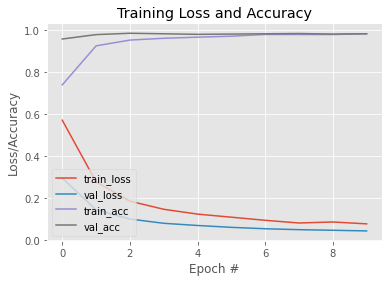

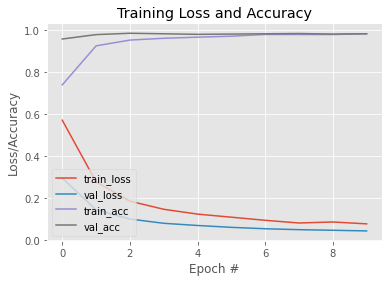

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")